In [73]:
import sys
sys.path.insert(0, '/home/ading/dev/empirical-mt')

import matplotlib.pyplot as plt

from pelic.gabors import makeGabors, makeGaussian
from pelic.calculate_contrast import CalculateContrast

import pandas as pd

from tqdm import tqdm 

from tuning import DirectionTuning, SpeedTuning, DisparityTuning

import numpy as np

from skimage import io, transform, util, img_as_float, img_as_ubyte
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
import skimage.draw as draw

import scipy.io as sio

import MT

from keras.layers import Input, Dense, Concatenate, Multiply
from keras.models import Model

size_ = 101
gabors = makeGabors(size_, center=None)
gaussian = makeGaussian(size_, sigma=5, center=None)

contrast_calculator = CalculateContrast(gabors, gaussian)

import tensorflow as tf

from os import listdir
from os.path import isfile, join, split, isdir, basename

from scipy import stats

import cv2

In [74]:
d = '../data/alov300++/pairwise_train_frac1_size76_ratio0.5_grayscale'

df2 = pd.read_json('../data/alov300++/pairwise_test_frac1_size76_ratio0.5_grayscale/index.json')

In [75]:
df2['offset'] = df2.apply(lambda r: (np.array(r['box2']) - np.array(r['box1'])), axis = 1) 

In [76]:
o = np.stack(df2['offset'].values, axis=0)

In [77]:
o.shape

(2688, 2, 2)

In [78]:
np.mean(np.abs(o)) / (76 - 1)

0.043609871031746031

In [79]:
p = np.load('../visual_tracking/bin/predictions.npy')

In [80]:
box2 = np.stack(df2['box2'].values, axis=0)

box2.shape

(2688, 2, 2)

In [81]:
np.mean(np.abs(p - box2)) / (76 - 1)

0.061247355793233191

In [82]:
df2['p'] = pd.Series(list(p), index=df2.index)

In [83]:
df2.head()

,box1,box2,feature_dir,frame_id,video_category,video_id,offset,p
0,"[[19, 25], [57, 51]]","[[19, 26], [57, 52]]",12-MovingCamera_video00013/00000136,136,movingcamera,12-MovingCamera_video00013,"[[0, 1], [0, 1]]","[[21.5893, 23.7187], [57.6549, 51.422]]"
1,"[[19, 30], [57, 46]]","[[15, 34], [53, 49]]",09-Confusion_video00033/00000254,254,confusion,09-Confusion_video00033,"[[-4, 4], [-4, 3]]","[[17.8001, 28.4032], [54.8346, 46.5332]]"
2,"[[25, 19], [51, 57]]","[[27, 22], [53, 59]]",14-LongDuration_video00003/00002196,2196,longduration,14-LongDuration_video00003,"[[2, 3], [2, 2]]","[[25.8833, 15.4844], [51.5447, 51.5263]]"
3,"[[20, 27], [57, 49]]","[[20, 27], [57, 49]]",11-Occlusion_video00025/00000754,754,occlusion,11-Occlusion_video00025,"[[0, 0], [0, 0]]","[[20.8309, 25.674], [57.3276, 47.6402]]"
4,"[[32, 20], [44, 57]]","[[32, 20], [44, 57]]",14-LongDuration_video00004/00000591,591,longduration,14-LongDuration_video00004,"[[0, 0], [0, 0]]","[[32.9993, 18.9148], [44.5026, 56.4649]]"


In [ ]:
d = '../data/alov300++/pairwise_test_frac1_size76_ratio0.5_grayscale'

In [ ]:
for _, r in df2.iterrows():
    plt.figure(figsize=(20, 20))
    
    # print(r['feature_dir'])
    
    f1_path = join(d, r['feature_dir'], 'prev_frame.png')
    f2_path = join(d, r['feature_dir'], 'frame.png')
    
    # f1
    f1 = gray2rgb(img_as_float(io.imread(f1_path)))
    rr, cc = draw.rectangle(r['box1'][0], r['box1'][1])
    f1[rr, cc, 0] = 1
    plt.subplot(1, 2, 1)
    io.imshow(f1)
    
    # f2
    f2 = gray2rgb(img_as_float(io.imread(f2_path)))
    rr, cc = draw.rectangle(r['box2'][0], r['box2'][1])
    #f2[rr, cc, 1] = 1
    
    rr, cc = draw.rectangle(r['p'][0].astype(np.int), r['p'][1].astype(np.int))
    f2[rr, cc, 0] = 1
    
    plt.subplot(1, 2, 2)
    io.imshow(f2)
    
    plt.show()
    

In [32]:
df2.head()

,box1,box2,feature_dir,frame_id,video_category,video_id
0,"[[19, 25], [57, 51]]","[[19, 26], [57, 52]]",12-MovingCamera_video00013/00000136,136,movingcamera,12-MovingCamera_video00013
1,"[[19, 30], [57, 46]]","[[15, 34], [53, 49]]",09-Confusion_video00033/00000254,254,confusion,09-Confusion_video00033
2,"[[25, 19], [51, 57]]","[[27, 22], [53, 59]]",14-LongDuration_video00003/00002196,2196,longduration,14-LongDuration_video00003
3,"[[20, 27], [57, 49]]","[[20, 27], [57, 49]]",11-Occlusion_video00025/00000754,754,occlusion,11-Occlusion_video00025
4,"[[32, 20], [44, 57]]","[[32, 20], [44, 57]]",14-LongDuration_video00004/00000591,591,longduration,14-LongDuration_video00004


In [45]:
d = '../data/alov300++/pairwise_test_frac1_size76_ratio0.5_grayscale'

def flow(r):
    #print(opf_filepath)
    prev_frame_filepath = join(d, r['feature_dir'], 'prev_frame.png')
    frame_filepath = join(d, r['feature_dir'], 'frame.png')
    
    prev_frame = io.imread(prev_frame_filepath, as_gray=True)
    frame = io.imread(frame_filepath, as_gray=True)

    # calculate optic flow using Farneback
    prev_frame_u8 = img_as_ubyte(prev_frame)
    frame_u8 = img_as_ubyte(frame)
    opt_flow_farneback = cv2.calcOpticalFlowFarneback(prev_frame_u8, frame_u8, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.1, flags=0)
    h = opt_flow_farneback[:, :, 1]
    v = opt_flow_farneback[:, :, 0]
    
    speed = np.sqrt(np.square(h) + np.square(v))
  
    
    return pd.Series({'speed': speed})

In [51]:
f = df2.sample(frac=1).apply(flow, axis=1)

In [53]:
fs = np.stack(f['speed'].values, axis=0)

In [57]:
fs.flatten()

array([  8.75358605e-11,   6.04182260e-10,   1.64226788e-09, ...,
         5.31592241e-06,   3.08563449e-06,   2.47338244e-06], dtype=float32)

In [63]:
s = pd.Series(fs.flatten())

In [65]:
s.describe()

count    1.552589e+07
mean     2.245123e+00
std      3.234418e+00
min      0.000000e+00
25%      1.851883e-01
50%      1.232003e+00
75%      3.492994e+00
max      5.973970e+02
dtype: float64

In [72]:
np.percentile(s, 95)

7.394679355621335

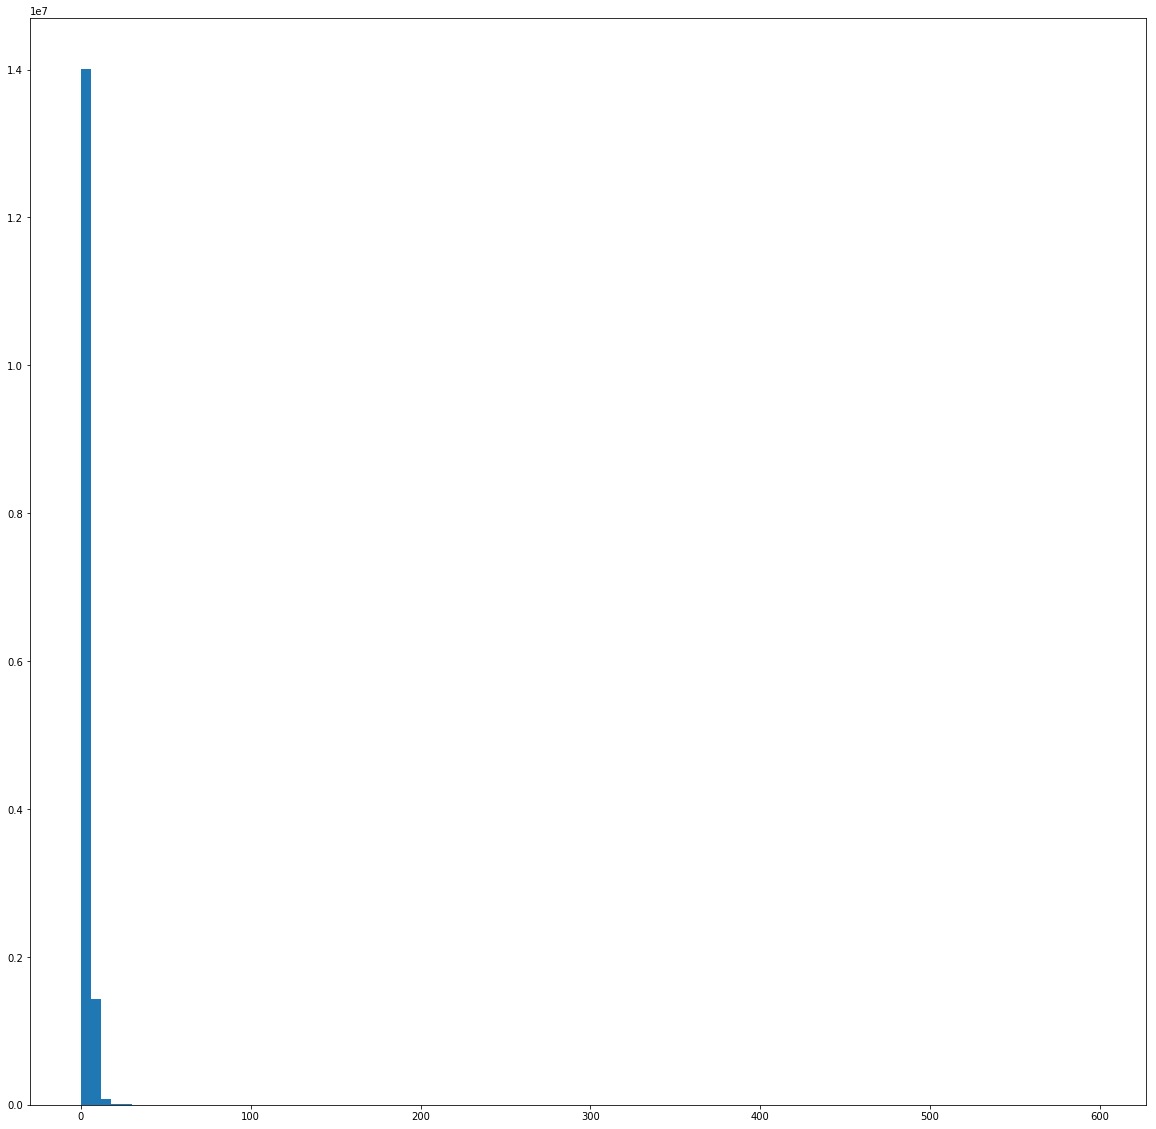

In [86]:
plt.figure(figsize=(20, 20))

plt.hist(s, bins=100, log=False)

plt.show()

In [85]:
8 * 8 * 64

4096